# 7주차 스터디

**퀀트 입문**

    1. MDD 계산

    2. 포트폴리오의 수익, 분산 구하기

    3. 주식(포트폴리오)의 베타 계산


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## MDD 계산

    MDD(Maximum Draw Down) : 비유적으로 말해 투자자가 투자 기간 동안 견뎌야 하는 고통의 최고치를 의미

공식:   $MDD =$ $Trough - Peak \over Peak$ 

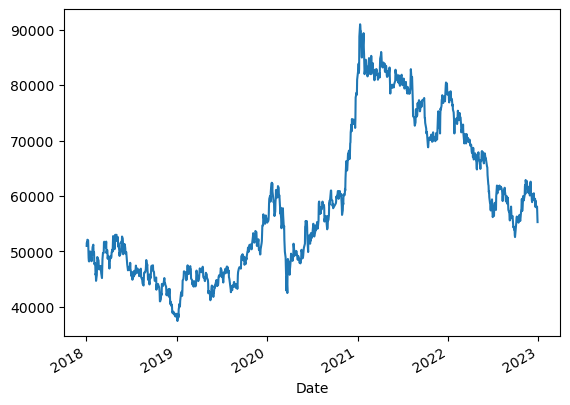

In [2]:
samsung = pd.read_csv("데이터/삼성전자주가.csv", index_col=0, parse_dates=True)
samsung.Close.plot();

In [3]:
# MDD 계산 
peak = samsung["Close"].cummax()
DD = (samsung["Close"] - peak) / peak
DD.min()

-0.421978021978022

In [4]:
# 언제 MDD를 찍었는지
idx = DD.argmin()
samsung.iloc[idx]

Open         53300
High         53700
Low          52600
Close        52600
Volume    13882080
Name: 2022-09-29 00:00:00, dtype: int64

## 포트폴리오의 수익, 분산 구하기

기대수익률:  $W$ $\cdot$ $E(R)$

분산 :   $W$ $\cdot$ $\sum$ $\cdot$ $W^T$   

In [5]:
stock_close = pd.DataFrame()

for name in ["HMM","삼성전자","에쓰오일","에코프로","엔씨소프트","현대차"]:
    stock_close[name] = pd.read_csv("데이터/{}주가.csv".format(name), 
                                    index_col=0, parse_dates=True).Close
    
stock_close

,HMM,삼성전자,에쓰오일,에코프로,엔씨소프트,현대차
Date,,,,,,
2018-01-02,5010,51020,117000,25698,446500,149500
2018-01-03,4790,51620,113500,24630,435000,150500
2018-01-04,4625,51080,113500,23918,422500,146500
2018-01-05,4635,52120,113000,24727,422000,149000
2018-01-08,4520,52020,111500,24144,420000,151000
...,...,...,...,...,...,...
2022-12-23,21700,58100,88000,108595,429500,157000
2022-12-26,21750,57900,89500,110926,432000,158000
2022-12-27,21850,58100,89100,111800,432000,158000


##### 1. Equal Weight인 경우 (1/6씩)

In [6]:
# weight 행렬 만들기
weight = np.array([1/6]*6)
weight

array([0.16666667, 0.16666667, 0.16666667, 0.16666667, 0.16666667,
       0.16666667])

In [7]:
# 포트폴리오의 기대 수익률 계산 (일간 수익률의 평균을 기대수익률로 사용) 
# 일간 수익률을 연간 수익률로 환산하기 위해서 250을 곱해줌
# (1년 중 영업일은 보통 250일)
mean_return = stock_close.pct_change().mean() * 250

np.dot(weight, mean_return)

0.17565084327134695

In [8]:
# 포트폴리오의 위험(분산) 계산
sigma = stock_close.pct_change().cov() * 250

np.dot(weight, np.dot(sigma, weight.T))

0.06205968075122592

##### 2. Animal Sprit인 경우 

에코프로에 포트폴리오의 절반을 담아보자

In [9]:
# weight 행렬 만들기
weight = np.array([0.1, 0.1,0.1,0.5,0.1,0.1])
weight

array([0.1, 0.1, 0.1, 0.5, 0.1, 0.1])

In [10]:
# 포트폴리오의 기대 수익률 계산 (일간 수익률의 평균을 기대수익률로 사용) 
mean_return = stock_close.pct_change().mean() * 250

np.dot(weight, mean_return)

0.2863272927045341

In [11]:
# 포트폴리오의 위험(분산) 계산
sigma = stock_close.pct_change().cov() * 250

np.dot(weight.T, np.dot(sigma, weight))

0.12477589559969107

## 베타($\beta$)를 계산해보자

베타란 주식시장의 전체 변동에 대한 개별 종목의 변동 정도를 측정한다 

분산투자로 제거할 수 없는 체계적인 위험(Systemic Risk)의 정도를 의미한다

베타는 개별 주식에 국한되는 개념은 아니고, 포트폴리오에 대해서도 계산할 수 있다. 포트폴리오의 개별 종목의 베타를 비중으로 가중평균 한 것이 포트폴리오의 베타가 된다

윈도우 크기에 따라 베타 값은 달라지게 된다

---

$\beta$를 구하는 두 가지 방법

1. 시장포트폴리오의 수익을 개별 자산의 수익에 회귀분석해서 구한다

2. $\beta =$ $\sigma_{im}\over\sigma^2_m$ : 자산 i와 시장포트폴리오의 공분산을 시장포트폴리오의 분산으로 나눈 것이다

In [12]:
# Market 인덱스를 가져와야 한다
market = pd.read_excel("데이터/지수.xlsx", index_col=0)
market.index.name = None #거슬리는거 제거

kospi = market.코스피.copy()
kospi

2018-01-02    2479.65
2018-01-03    2486.35
2018-01-04    2466.46
2018-01-05    2497.52
2018-01-08    2513.28
               ...   
2022-12-23    2313.69
2022-12-26    2317.14
2022-12-27    2332.79
2022-12-28    2280.45
2022-12-29    2236.40
Name: 코스피, Length: 1232, dtype: float64

첫번째 방법(회귀분석)

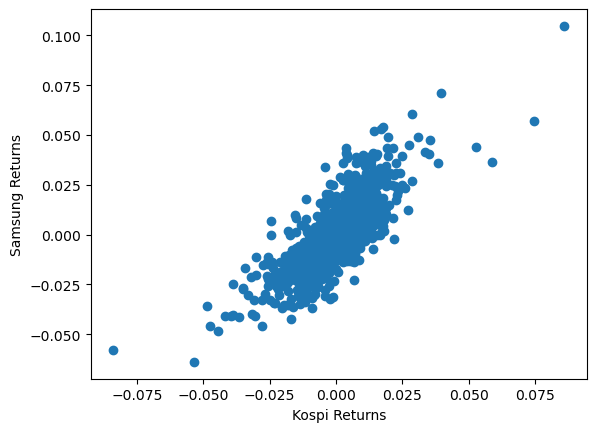

In [13]:
# 삼성전자의 베타 구해보기 (window는 5년)
samsung = stock_close.삼성전자

samsung_pct = samsung.pct_change().dropna().values
kospi_pct = kospi.pct_change().dropna().values

plt.scatter(kospi_pct, samsung_pct)
plt.xlabel("Kospi Returns")
plt.ylabel("Samsung Returns");

In [14]:
# Regression으로 베타를 구해보자
from sklearn.linear_model import LinearRegression
model = LinearRegression()
model.fit(kospi_pct.reshape(-1,1), samsung_pct)

# 삼성전자의 5년간 베타를 의미함
print("모델의 기울기(베타): ", model.coef_[0])

모델의 기울기(베타):  1.0810016453106452


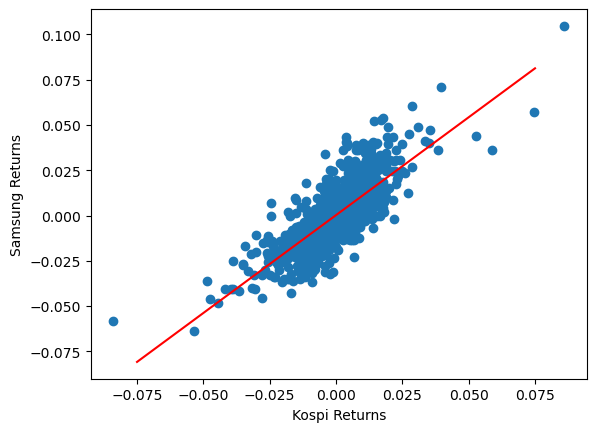

In [15]:
# Regrission Line을 시각화 해보자
x = [[-0.075],[0.075]]
y = model.predict(x)

# 회귀선 그리기
plt.plot(x,y, c="r")

# 기존 수익 산점도 그리기 
plt.scatter(kospi_pct, samsung_pct)
plt.xlabel("Kospi Returns")
plt.ylabel("Samsung Returns");

두번째 방법 (공식으로)

$\beta =$ $\sigma_{im}\over\sigma^2_m$

In [16]:
# 공분산을 계산
covar = np.cov(samsung_pct, kospi_pct)
sigma_im= covar[0,1]

# 마켓의 분산을 계산
sigma_m = kospi_pct.var()

# 삼성전자의 5년간 베타
sigma_im / sigma_m

1.0818805084369136

## 퀀트 전략 구현하고 평가하기

20일 이동 평균선을 돌파하면 주식을 사고, 그 반대일 때는 파는 전략을 구현해봅시다

In [74]:
# 삼성전자 주가를 사용하겠습니다
samsung = stock_close[["삼성전자"]].copy()
samsung.columns = ["price"]

# 2년치 주가만 사용하겠습니다
samsung = samsung.loc["2020-01-01":]

In [75]:
# 20일 이평선을 데이터프레임에 추가하겠습니다
samsung["ma20"] = samsung.rolling(window=20).mean()
samsung.tail()

,price,ma20
Date,,
2022-12-23,58100,59785.0
2022-12-26,57900,59675.0
2022-12-27,58100,59550.0
2022-12-28,56600,59270.0
2022-12-29,55300,58905.0


In [76]:
# 포지션 진입과 청산을 기록할 거래 기록지(Book)을 만들어야 합니다

book = samsung[["price"]].copy()
# 거래를 기록
book["trade"] = 0
# 거래의 수익률을 기록
book["rtn"] = 1
book.head()

,price,trade,rtn
Date,,,
2020-01-02,55200,0,1
2020-01-03,55500,0,1
2020-01-06,55500,0,1
2020-01-07,55800,0,1
2020-01-08,56800,0,1


In [77]:
# 전략을 구현하겠습니다. 해당 전략은 Event-Driven 전략이라 for문을 통해 구현하면 간편합니다
for date in samsung.index:
    # 매수 조건
    if samsung.loc[date, "price"] > samsung.loc[date, "ma20"]:
        book.loc[date, "trade"] = 1

In [78]:
# book에 기록된 trade일지로 수익을 구하면 됩니다
hold = False

for date in book.index:
    # 포지션 진입(주식 안 가지고 있다가 다음날 매수하는 경우)
    if (book.loc[date, "trade"] == 1) and (book.shift(1).loc[date, "trade"] == 0):
        buy_price = book.loc[date, "price"]
        print("포지션 진입, 매수가: {}, 매수일: {}".format(buy_price, date))
        hold = True
    
    # 포지션 청산 (주식 가지고 있다가 다음날 매도하는 경우)
    elif (book.loc[date, "trade"] == 0) and (book.shift(1).loc[date, "trade"] == 1):
        sell_price = book.loc[date, "price"]
        rt = ((sell_price - buy_price) / buy_price + 1)
        print("포지션 청산, 매도가: {}, 매도일: {}, 수익:{}".format(sell_price, date, rt))
        # 변수 초기화
        hold = False
        buy_price, sell_price = 0,0
    
    # 수익률 계산(주식을 가지고 있는 경우)
    elif hold == True:
        rtn = (book.loc[date, "price"] / book.shift(1).loc[date, "price"])
        book.loc[date, "rtn"] = rtn

포지션 진입, 매수가: 59500, 매수일: 2020-02-05 00:00:00
포지션 청산, 매도가: 59700, 매도일: 2020-02-10 00:00:00, 수익:1.0033613445378151
포지션 진입, 매수가: 59900, 매수일: 2020-02-11 00:00:00
포지션 청산, 매도가: 59800, 매도일: 2020-02-18 00:00:00, 수익:0.998330550918197
포지션 진입, 매수가: 60200, 매수일: 2020-02-19 00:00:00
포지션 청산, 매도가: 59200, 매도일: 2020-02-21 00:00:00, 수익:0.9833887043189369
포지션 진입, 매수가: 48700, 매수일: 2020-04-06 00:00:00
포지션 청산, 매도가: 48500, 매도일: 2020-05-04 00:00:00, 수익:0.9958932238193019
포지션 진입, 매수가: 50300, 매수일: 2020-05-19 00:00:00
포지션 청산, 매도가: 48750, 매도일: 2020-05-22 00:00:00, 수익:0.9691848906560636
포지션 진입, 매수가: 49250, 매수일: 2020-05-26 00:00:00
포지션 청산, 매도가: 49900, 매도일: 2020-06-15 00:00:00, 수익:1.0131979695431472
포지션 진입, 매수가: 52100, 매수일: 2020-06-16 00:00:00
포지션 청산, 매도가: 52000, 매도일: 2020-06-22 00:00:00, 수익:0.9980806142034548
포지션 진입, 매수가: 52900, 매수일: 2020-06-24 00:00:00
포지션 청산, 매도가: 51900, 매도일: 2020-06-25 00:00:00, 수익:0.9810964083175804
포지션 진입, 매수가: 53300, 매수일: 2020-06-26 00:00:00
포지션 청산, 매도가: 52400, 매도일: 2020-06-29 00:00:00, 수익:0.9

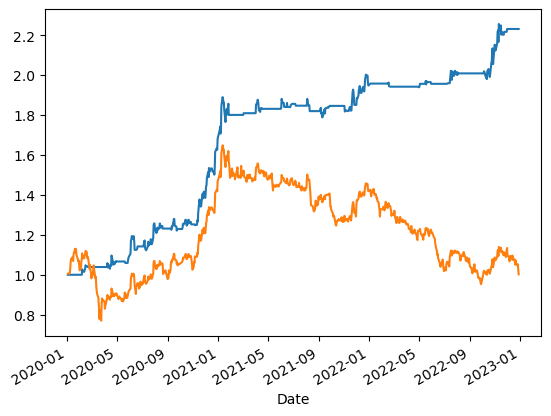

In [86]:
# 전략의 수익
book.rtn.cumprod().plot()

# 삼성전자 Buy & Hold 전략
(book.price.pct_change() + 1).cumprod().plot();